### **Objective of the project**

The objective of this project is to efficiently process a large dataset of images to compute the mean face representation using PyTorch. The steps involve:

1. **Data Loading**:
   - Load the dataset and preprocess images using transformations like resizing and normalization.

2. **Custom Data Handling**:
   - Define a collate function to ensure seamless data transfer to the GPU for efficient batch processing.

3. **Mean Face Calculation**:
   - Process the dataset in batches to compute the cumulative sum of pixel values and the total count of images.
   - Utilize GPU acceleration and multi-threading to optimize the computation.

4. **Visualization**:
   - Display the computed mean face to verify the results and understand the dataset's average representation.

The project is aimed to leverage PyTorch's capabilities for high-performance data processing and efficient GPU utilization.

Python version used : 3.9

In [27]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset 


In [28]:
# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [29]:
# Declare constants
isUsedWholeDataSet = False
maxSubSet = 60000

### **Image Transformation and Batch Collation**

We define image preprocessing and batch handling for efficient data loading and GPU utilization.

---
 

In [30]:
# Define transformation for resizing and normalizing images
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
]) 

In [31]:
# Define a collate function to move each batch to GPU
def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images).to(device)  # Stack images and move to GPU
    labels = torch.tensor(labels).to(device)  # Convert labels to tensor and move to GPU
    return images, labels


### **Dataset Loading and DataLoader Initialization**

We set up the dataset and data loader for efficient batch processing.

---



In [32]:
# Load the full dataset
dataset = datasets.ImageFolder(root="./img_align_celeba", transform=transform)

selectDataSet = dataset if isUsedWholeDataSet else Subset(
    dataset, range(maxSubSet))

# Create DataLoader with the custom collate function
batch_size = 2048   # Adjust based on your GPU memory
dataloader = DataLoader(selectDataSet, batch_size=batch_size,shuffle=False)


In [33]:
print(f"Number of samples in selectDataSet: {len(selectDataSet)}")


Number of samples in selectDataSet: 60000


In [34]:
firstBatch = next(iter(dataloader))

(firstBatchImages,firstBatchLabel) = firstBatch

In [35]:
firstBatchImages[1].size()

torch.Size([3, 128, 128])

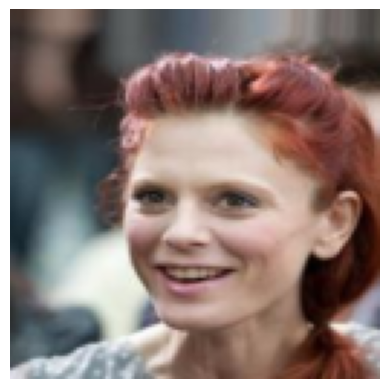

In [36]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Get the first image from the batch
image = firstBatchImages[1]

# Convert the tensor image to a format suitable for displaying
image = F.to_pil_image(image)

# Display the image
plt.imshow(image)
plt.axis('off')  # Optional: Turn off the axes
plt.show()


# Multi-GPU Support for Mean Face Calculation

### **Overview**
We define a custom PyTorch model (`MeanFaceModel`) for calculating the mean face and sets it up for multi-GPU usage using `torch.nn.DataParallel`.

---


In [37]:
import torch.nn as nn

# Define a simple model to compute the mean
class MeanFaceModel(nn.Module):
    def __init__(self):
        super(MeanFaceModel, self).__init__()
        self.mean_face = nn.Parameter(torch.zeros(3, 128, 128, dtype=torch.float32), requires_grad=False)
        self.num_images = 0

    def forward(self, images):
        # Accumulate sum and count
        batch_sum = images.sum(dim=0)  # Sum over the batch
        batch_size = images.size(0)
        return batch_sum, batch_size
    
model = MeanFaceModel().to(device)
model = nn.DataParallel(model).to(device)  # Enable multi-GPU support

In [38]:
# Get GPU properties
device_id = 0  # Use the first GPU (or change if using multiple GPUs)
device_properties = torch.cuda.get_device_properties(device_id)

# Calculate the number of CUDA cores
cuda_cores_per_sm = {
    "3.0": 192,  # Kepler
    "3.5": 192,
    "3.7": 192,
    "5.0": 128,  # Maxwell
    "5.2": 128,
    "5.3": 128,
    "6.0": 64,   # Pascal
    "6.1": 128,
    "6.2": 128,
    "7.0": 64,   # Volta
    "7.5": 64,   # Turing
    "8.0": 64,   # Ampere
    "8.6": 128,  # Ampere
    "8.9": 128   # Ada Lovelace
}
compute_capability = f"{device_properties.major}.{device_properties.minor}"
cores_per_sm = cuda_cores_per_sm.get(compute_capability, "Unknown")
total_cores = device_properties.multi_processor_count * cores_per_sm

# Display information
print(f"Device: {device_properties.name}")
print(f"Compute Capability: {compute_capability}")
print(f"Number of Streaming Multiprocessors: {device_properties.multi_processor_count}")
print(f"Total CUDA Cores: {total_cores}")


Device: NVIDIA GeForce RTX 4060 Laptop GPU
Compute Capability: 8.9
Number of Streaming Multiprocessors: 24
Total CUDA Cores: 3072


### **Mean Face Calculation Process**

This process involves calculating the average pixel values (mean face) from a dataset using PyTorch. The key steps include:

1. **Initialization**:
   - A tensor (`total_sum`) is initialized to accumulate pixel values.
   - A counter (`total_count`) is used to keep track of the number of images processed.

2. **Data Loading and GPU Computation**:
   - Images are loaded in batches using a PyTorch `DataLoader`.
   - Each batch is moved to the GPU for processing in `float16` precision for efficiency.
   - The model processes the images to compute the sum of pixel values (`batch_sum`) and the batch size (`batch_size`).
   - The results are accumulated into `total_sum` and `total_count`.

3. **Final Calculation**:
   - The mean face is calculated by dividing `total_sum` by `total_count`.
   - The result is moved back to the CPU and converted to NumPy for visualization.

---

In [44]:
# Initialize a tensor to accumulate pixel values
total_sum = torch.zeros(3, 128, 128, device=device)
total_count = 0

for images, _ in dataloader:
    images = images.to(device, dtype=torch.float16)  # Move images to GPU in FP16
    batch_sum, batch_size = model(images)
    total_sum += batch_sum.to(torch.float32)  # Convert to FP32 for stability
    total_count += batch_size
    print(f'{total_count} out of {len(selectDataSet)}')

# Compute the average (mean face) by dividing by the number of images
mean_face = total_sum / total_count

# Move the result back to CPU for visualization
mean_face_np = mean_face.permute(1, 2, 0).cpu().numpy()



64 out of 60000
128 out of 60000
192 out of 60000
256 out of 60000
320 out of 60000
384 out of 60000
448 out of 60000
512 out of 60000
576 out of 60000
640 out of 60000
704 out of 60000
768 out of 60000
832 out of 60000
896 out of 60000
960 out of 60000
1024 out of 60000
1088 out of 60000
1152 out of 60000
1216 out of 60000
1280 out of 60000
1344 out of 60000
1408 out of 60000
1472 out of 60000
1536 out of 60000
1600 out of 60000
1664 out of 60000
1728 out of 60000
1792 out of 60000
1856 out of 60000
1920 out of 60000
1984 out of 60000
2048 out of 60000
2112 out of 60000
2176 out of 60000
2240 out of 60000
2304 out of 60000
2368 out of 60000
2432 out of 60000
2496 out of 60000
2560 out of 60000
2624 out of 60000
2688 out of 60000
2752 out of 60000
2816 out of 60000
2880 out of 60000
2944 out of 60000
3008 out of 60000
3072 out of 60000
3136 out of 60000
3200 out of 60000
3264 out of 60000
3328 out of 60000
3392 out of 60000
3456 out of 60000
3520 out of 60000
3584 out of 60000
3648 out

# Parallelizing Mean Face Calculation with ThreadPoolExecutor

### **Overview**
This cell demonstrates how to parallelize the computation of the mean face using Python's `ThreadPoolExecutor`. Each batch of images is processed concurrently by worker threads, reducing the overall processing time.

---

### **Steps Involved**

1. **Helper Function**:
   - `process_batch(batch)`: Processes a single batch of images by transferring them to the GPU, computing the batch sum and size, and returning these values.

2. **Initialize Totals**:
   - `total_sum` accumulates pixel values.
   - `total_count` keeps track of the number of images processed.

3. **ThreadPoolExecutor**:
   - The `executor.map()` function distributes the processing of batches across multiple threads (`max_workers=5`).

4. **Result Aggregation**:
   - After processing all batches in parallel, the results (`batch_sum` and `batch_size`) are aggregated to compute the mean face.

5. **Visualization**:
   - The mean face tensor is converted to NumPy and visualized.

---

In [41]:
from concurrent.futures import ThreadPoolExecutor

# Helper function for processing a batch
def process_batch(batch):
    images, _ = batch
    images = images.to(device, dtype=torch.float16)  # Move to GPU
    batch_sum, batch_size = model(images)  # Model computation
    return batch_sum.to(torch.float32), batch_size

# Initialize totals
total_sum = torch.zeros(3, 128, 128, device=device, dtype=torch.float32)
total_count = 0

# Use ThreadPoolExecutor for parallelism
with ThreadPoolExecutor(max_workers=5) as executor:  # Adjust workers
    results = list(executor.map(process_batch, dataloader))

# Aggregate results
for batch_sum, batch_size in results:
    total_sum += batch_sum
    total_count += batch_size
    print(f'{total_count} out of {len(selectDataSet)}')


# Compute mean face
mean_face = total_sum / total_count

# Convert to NumPy for visualization
mean_face_np = mean_face.permute(1, 2, 0).cpu().numpy()


64 out of 60000
128 out of 60000
192 out of 60000
256 out of 60000
320 out of 60000
384 out of 60000
448 out of 60000
512 out of 60000
576 out of 60000
640 out of 60000
704 out of 60000
768 out of 60000
832 out of 60000
896 out of 60000
960 out of 60000
1024 out of 60000
1088 out of 60000
1152 out of 60000
1216 out of 60000
1280 out of 60000
1344 out of 60000
1408 out of 60000
1472 out of 60000
1536 out of 60000
1600 out of 60000
1664 out of 60000
1728 out of 60000
1792 out of 60000
1856 out of 60000
1920 out of 60000
1984 out of 60000
2048 out of 60000
2112 out of 60000
2176 out of 60000
2240 out of 60000
2304 out of 60000
2368 out of 60000
2432 out of 60000
2496 out of 60000
2560 out of 60000
2624 out of 60000
2688 out of 60000
2752 out of 60000
2816 out of 60000
2880 out of 60000
2944 out of 60000
3008 out of 60000
3072 out of 60000
3136 out of 60000
3200 out of 60000
3264 out of 60000
3328 out of 60000
3392 out of 60000
3456 out of 60000
3520 out of 60000
3584 out of 60000
3648 out

### **Why the Normal For Loop is Faster than Concurrency**

1. **Thread Overhead**:
   - Using `ThreadPoolExecutor` introduces additional overhead for creating, managing, and synchronizing threads. This overhead becomes a bottleneck for GPU-heavy tasks where the GPU can handle computations efficiently without threading.

2. **Global Interpreter Lock (GIL)**:
   - Python's GIL restricts true parallelism for CPU-bound tasks when using threads. This limitation leads to minimal benefits when processing batches concurrently on the CPU.

3. **Efficient GPU Utilization**:
   - The normal for loop processes one batch at a time, maximizing GPU utilization. In contrast, concurrent threads introduce delays when transferring batches to the GPU, resulting in inefficient GPU usage.

4. **Disruption of `DataLoader` Optimization**:
   - PyTorch's `DataLoader` is optimized for sequential prefetching and caching. Concurrency interferes with these optimizations, causing additional delays.

5. **GPU-Bound Workload**:
   - Since the workload primarily relies on the GPU, adding concurrency on the CPU adds unnecessary overhead without improving performance. GPU operations are already parallelized internally.

---

### **Key Takeaway**
For GPU-heavy operations, a normal for loop is faster because:
- It avoids the thread management overhead.
- It fully utilizes PyTorch's efficient data loading and GPU execution pipeline.


### **Image Result**

 

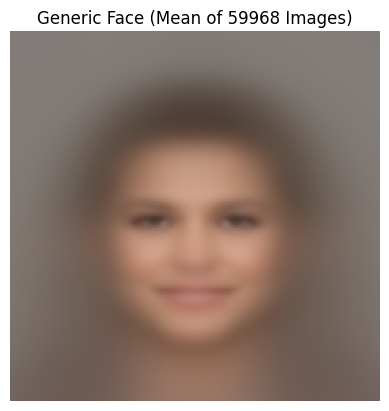

In [42]:
# Plot the "average" face
plt.imshow(mean_face_np)
plt.axis('off')
plt.title(f'Generic Face (Mean of {total_count} Images)')
plt.show()

### **Comparing CPU to GPU performance**

Here we introduce two functions - `process_batch_cpu` and `process_batch_gpu` to ensure that the batches are either computed on the CPU or GPU respectively. We also use a function `measure_time` to collect the performance data of both `process_batch_cpu` and `process_batch_gpu`. These results are then displayed on a graph with the `matplotlib` library.

CPU processing time: 65.6098 seconds
GPU processing time: 64.9880 seconds


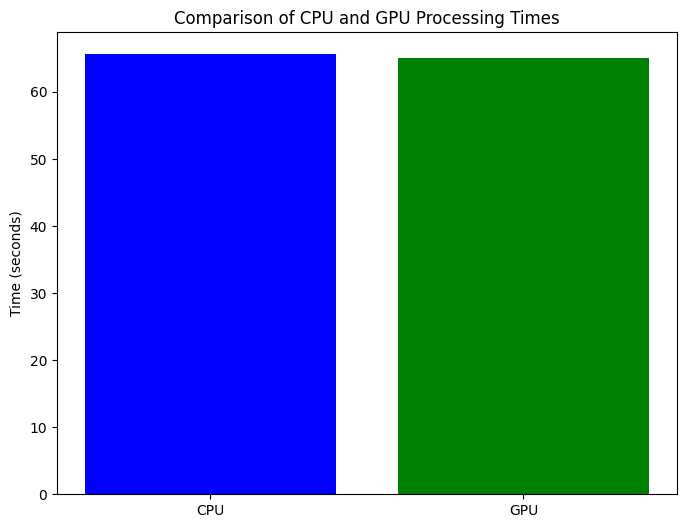

In [43]:
import torch
import time
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

# Function to process batches (CPU)
def process_batch_cpu(batch):
    images, _ = batch
    images = images.to(device, dtype=torch.float32)  # Ensure to stay on CPU
    batch_sum, batch_size = model(images)  # Model computation
    return batch_sum.to(torch.float32), batch_size

# Function to process batches (GPU)
def process_batch_gpu(batch):
    images, _ = batch
    images = images.to(device, dtype=torch.float16)  # Move to GPU
    batch_sum, batch_size = model(images)  # Model computation
    return batch_sum.to(torch.float32), batch_size

# Helper function to measure time for processing
def measure_time(processing_function, dataloader, device, max_workers=5):
    start_time = time.time()

    # Use ThreadPoolExecutor for parallelism
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(executor.map(processing_function, dataloader))

    total_time = time.time() - start_time
    return total_time

# Initialize totals
total_sum = torch.zeros(3, 128, 128, device=device, dtype=torch.float32)
total_count = 0

# Measure time for CPU processing
cpu_time = measure_time(process_batch_cpu, dataloader, device, max_workers=5)
print(f"CPU processing time: {cpu_time:.4f} seconds")

# Reset totals for GPU test
total_sum.fill_(0)
total_count = 0

# Measure time for GPU processing
gpu_time = measure_time(process_batch_gpu, dataloader, device, max_workers=5)
print(f"GPU processing time: {gpu_time:.4f} seconds")

# Create a bar plot to compare CPU and GPU times
times = [cpu_time, gpu_time]
labels = ['CPU', 'GPU']

plt.figure(figsize=(8, 6))
plt.bar(labels, times, color=['blue', 'green'])
plt.ylabel('Time (seconds)')
plt.title('Comparison of CPU and GPU Processing Times')
plt.show()
